# About

Notebook inspired by the example of Dimensionality Reduction done in the course Machine Learning Modeling Pipelines in Production, by DeepLearning.AI.

Notebook Reference: https://colab.research.google.com/drive/1Cf0JMZ9RQdpmwsJ0PxSxm6IKYtrWr02j#scrollTo=MPsBWkL07Srw.

[25-Oct-2021] This notebook was extended to capture background knowledge from NLP from the CS224U 2019 - Natural Language Understanding course from Stanford [CS224U-2019 - Natural Language Understanding - Stanford Univerity](https://web.stanford.edu/class/cs224u/2019/index.html). 


# Background:

## Vector Comparison

Common vector comparison measures are:
- Euclidean distance between vectors u and v: $euclidean(u,v) = \sqrt{\sum_{i=1}^{n}\left | u_{i}- v_{i}] \right |^2}$
- Cosine distance
- Matching coefficient
- Jaccard distance
- Dice distance
- Overlap
- KL divergence

Based on [Christopher Potts](https://web.stanford.edu/class/cs224u/2019/materials/cs224u-2019-vsm.pdf):
- Euclidean and Jaccard and Dice with raw count vectors will tend to favor raw frequency over distributional patters
- Euclidean with L2-normed vectors is equivalent to cosine with respect to ranking.
- Jaccard and Dice are equivalent w.r.t. ranking.



## Basic reweighting
Reweighting of vectors in natural language can amplify the importance and trustworthy of words in a text. The idea is to reveal what is important. Methods for reweighting are:
- L2 norming
- Probability distribution
- Observed/expected
- Pointwise Mutual Information (PMI)
- Positive PMI.
- TF-IDF: Term Frequency - Inverse Document Frequency


Pointwise Mutual Information (PMI) is observed/expected in the log-space (with log(0) = 0.
Based on [Christopher Potts](https://web.stanford.edu/class/cs224u/2019/materials/cs224u-2019-vsm.pdf):
- Many weighting schemes end up favoring rare events that may not be trustworthy.
- PMI and its variant will amplify the values of counts that are tiny relative to their row and columns. 
- TF-IDF severly punishes words that appear in many documents - it behaves oddly for dense matrices, which can include word x word matrices.



In [1]:
# General use imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import sys

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.datasets import fetch_20newsgroups

In [73]:
# Helper function from Christopher Potts used on the course CS224u, Stanford, Spring 2021 are used in the notebook.
# Source github link is here: https://github.com/cgpotts/cs224u
# Instead of using the word-to-word matrixes from CS224u, we used the dataset from 20newsgroups from sklearn and 
# generate the co-occurance matrix for the 100 first rows of this dataset.

import os
import vsm
import utils

In [74]:
# 20newsgroups dataset 
# Test using 20newsgroups dataset from https://scikit-learn.org/stable/datasets/real_world.html#the-20-newsgroups-text-dataset
# Download data
data = fetch_20newsgroups(remove=('headers', 'footers', 'quotes'))

# Get the actual text data from the sklearn Bunch
data = data.get("data")

In [75]:
print(data[:1])

['I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.']


In [76]:
#Lets generate the co-occurance matrix

from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(ngram_range=(1,1)) # default unigram model
X = vectorizer.fit_transform(data[:100])
Xc = (X.T * X) # matrix manipulation
Xc.setdiag(0) # set the diagonals to be zeroes as it's pointless to be 1

#Convert into matrix
names = vectorizer.get_feature_names() # This are the entity names (i.e. keywords)
#print(names)
df = pd.DataFrame(data = Xc.toarray(), columns = names, index = names)
#df.to_csv('20newsgroups.csv', sep = ',')
df.head()

,00,000,0005895485,01,02,02194,0320,04,05,06,...,ysc,yscvax,zangezour,zangibasar,zealand,zeik,zilkade,zone,zoologists,zoom
00,0,0,0,6,4,0,0,4,6,5,...,1,1,0,0,0,0,0,0,0,0
000,0,0,0,0,0,0,5,0,0,0,...,0,0,5,5,0,0,5,0,0,0
0005895485,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
01,6,0,0,0,24,0,0,24,36,30,...,6,6,0,0,0,0,0,0,0,0
02,4,0,0,24,0,0,0,16,24,20,...,4,4,0,0,2,0,0,1,0,0


## Lets compare different distance metrics (i.e. Euclidean, Pointwise Mutual Information and TF-IDF

In [78]:
# Check the neighbor distance using Euclidean
vsm.neighbors('car', df, distfunc=vsm.euclidean).head()

car            0.000000
insurance    442.483898
25           443.953826
rate         530.062260
same         540.973197
dtype: float64

In [79]:
# Check the neighbor distance using PMI (Pointwise Mutual Information) 
df_pmi = vsm.pmi(df)
vsm.neighbors('car', df_pmi).head()

car          0.000000
sports       0.134340
turbo        0.153308
toyota       0.162001
accidents    0.173207
dtype: float64

In [80]:
# Check the neighbor distance using TFIDF - Term Frequency - Inverse Document Frequency
df_tfidf = vsm.tfidf(df)
vsm.neighbors('car', df_tfidf).head()

car               0.000000
sports            0.214020
turbo             0.362690
classification    0.369355
corrado           0.369355
dtype: float64

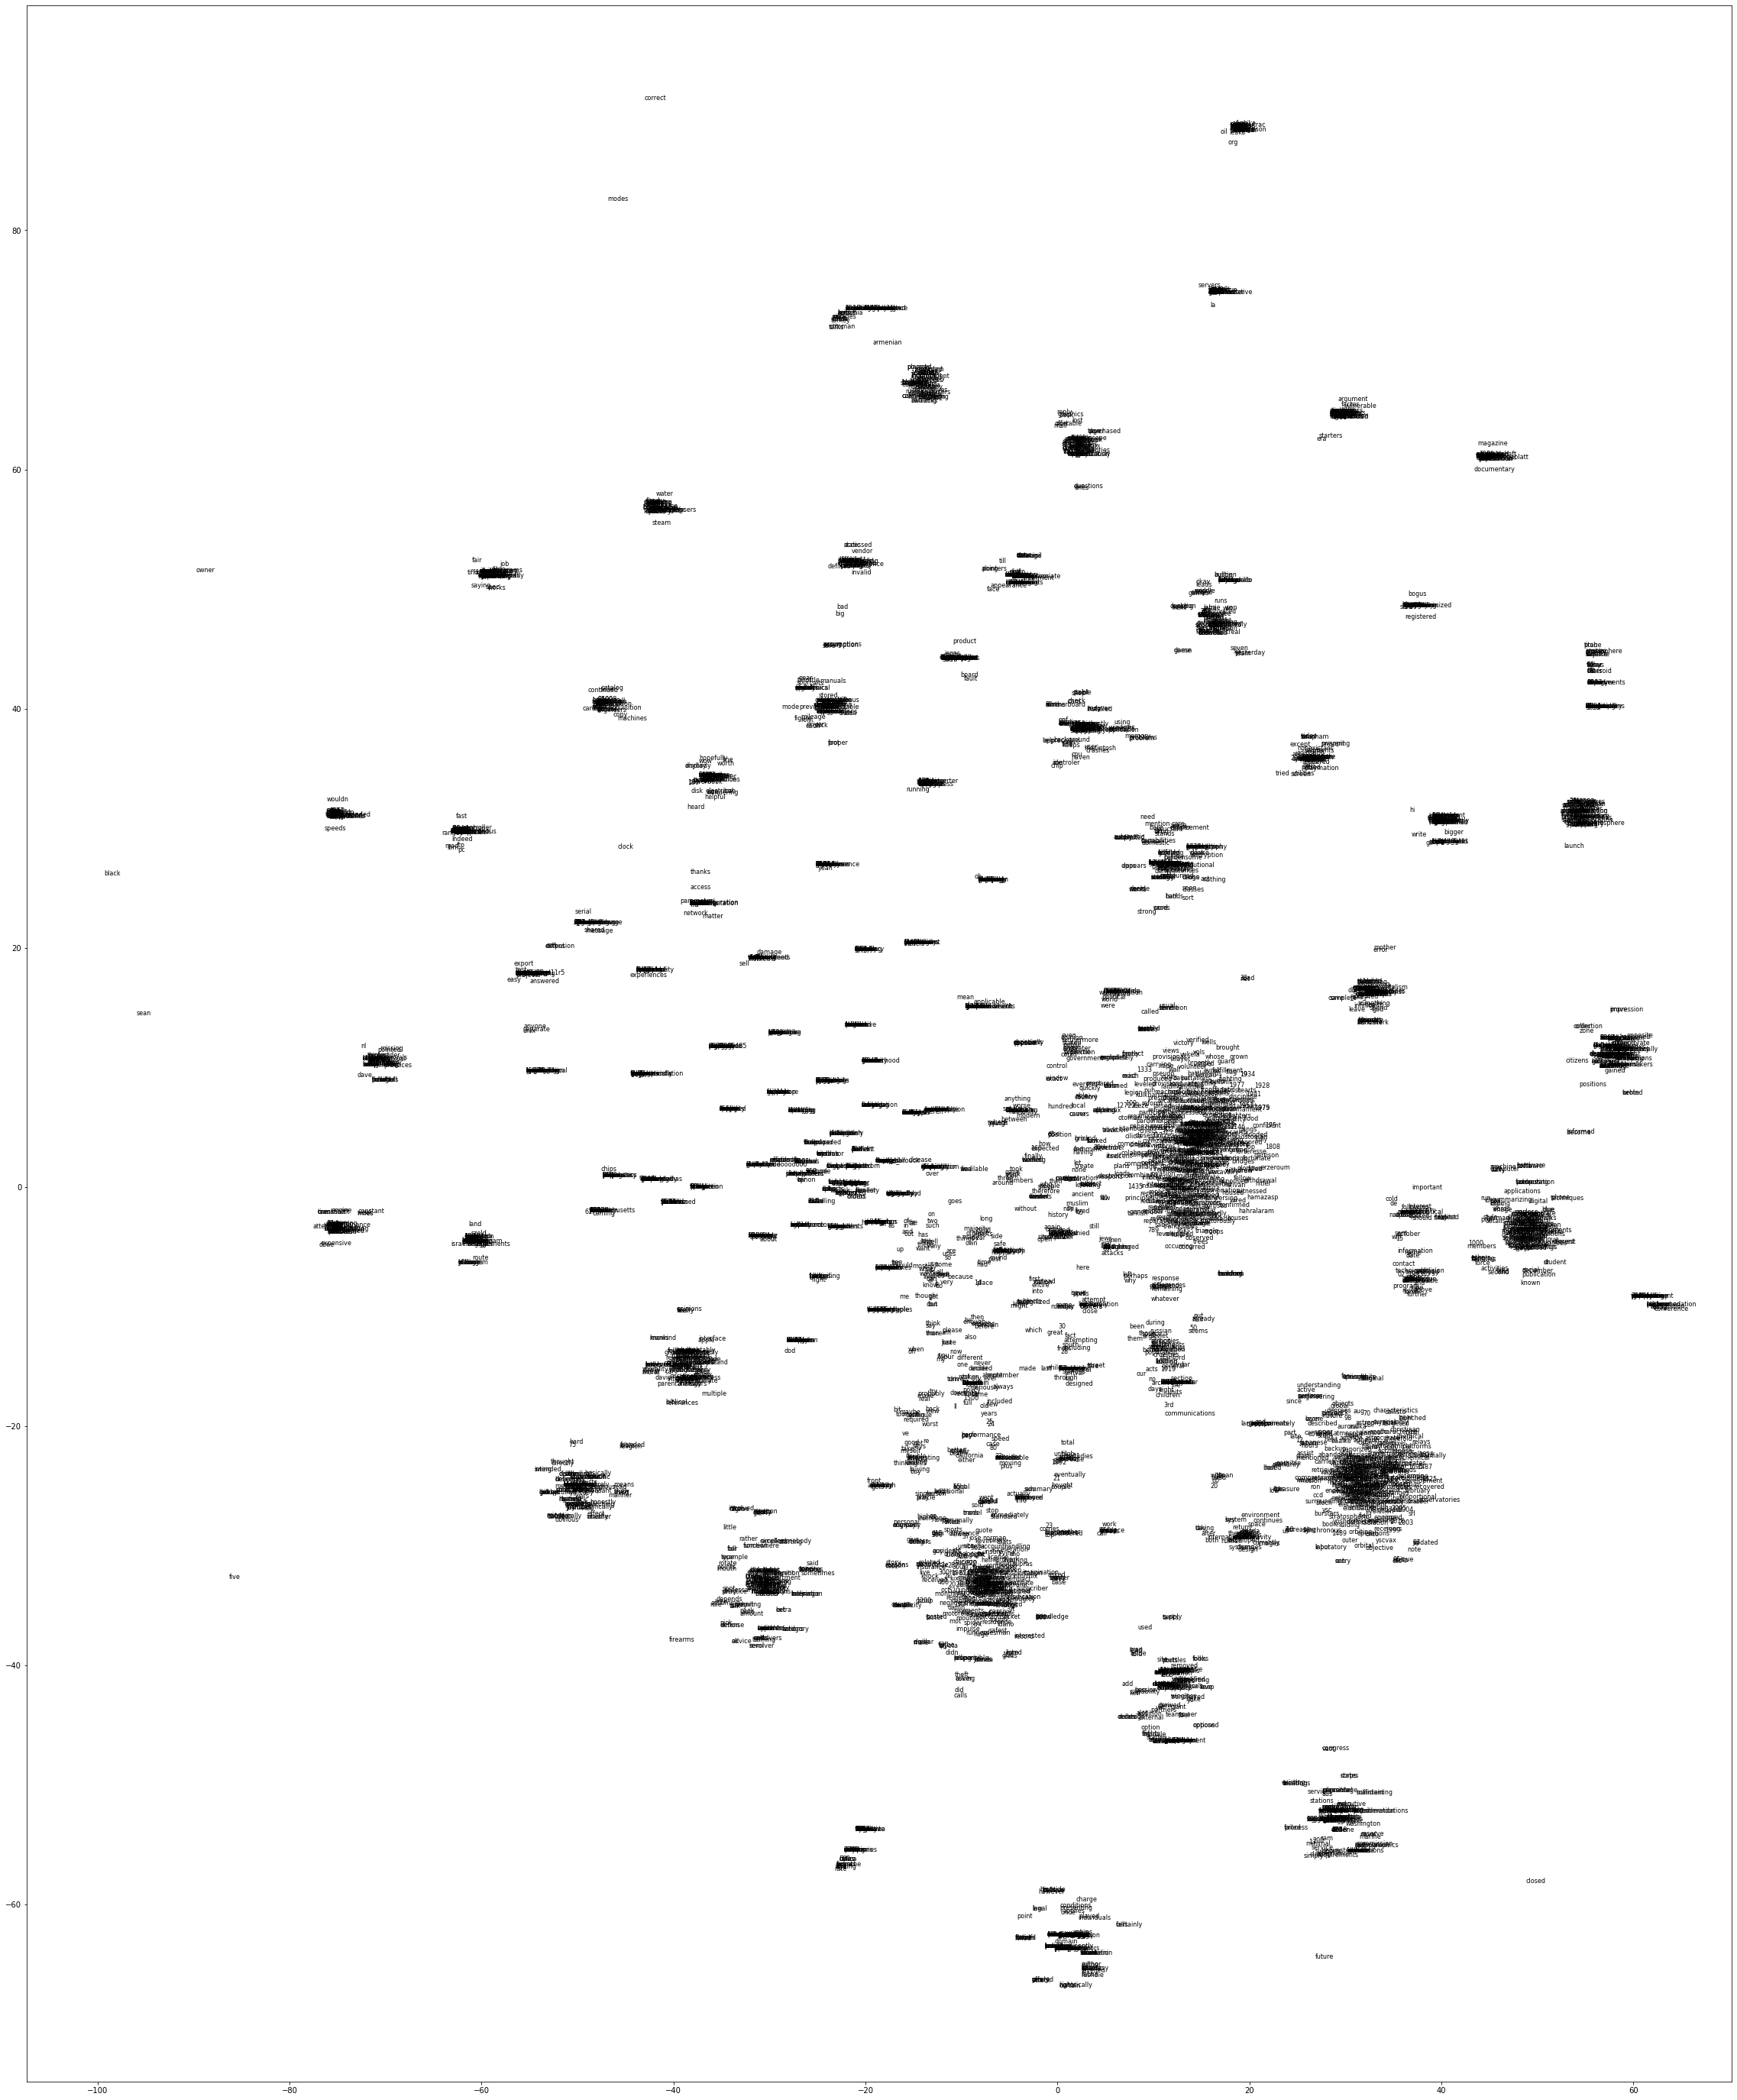

In [68]:
#Using the helper function to visualize the PMI results using T-SNE
vsm.tsne_viz(df_pmi, output_filename='pmi-test')

# Dimensionality Reduction
The "curse of dimensionaliy" is a known concept on machine learning (ML). In summary it relates to the fact that too many features can be a problem for ML algorithms.

Examples of dimentionality reductions are:
- Latent Semantic Analysis (LSA)
- Principa Component Analysis (PCA)
- Latent Dirichlet Allocation (LDA)
- Non-Negative Matrix Factorization (NMF)
- Independent Component Analysis (ICA)
- Singular value decomposition (SVD)

Use [sklearn.decomposition](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.decomposition) and [sklearn.manifold](https://scikit-learn.org/stable/modules/manifold.html) for more information.


## NMF - non-negative matrix factorization.
In this section of the notebook I am going to concentrate on NMF - non-negative matrix factorization.


NMF is a dimensionality reduction technique in unsupervised learning, but in contrast with PCA, the NMF model is interpretable. NMF requires the sample features to be non-negative, thus NMF can tend to lose more information when truncating.

NMF in text minining consider the bag-of-words matrix representation where each row corresponds to a word, and each column to a document. 

NMF will produce two matrices W and H, thus we can write V = W x H. 
According to [COLYER](https://blog.acolyer.org/2019/02/18/the-why-and-how-of-nonnegative-matrix-factorization/), the columns W can be interpreted as the terms to topic information (i.e. topic/bags of words).  H represents the importance of the given topic to a a given document.

We can be write NMF as:
term-document matrix (V) = terms/topics (W) + topics/docs (H)

In practise, 
the inputs is:
- count vectorizer or TF-IDF vectorizer

the parameters to tune are:
- Number of topics
- text preprocessing (e.g. stop words, min/max doc frequency, parts of speech)

the output:
- W matrix representing relation between terms and topics
- H matrix representing how to use the topics to reconstruct original documents (i.e. documents to topics relation)

![NMF](./images/NMF.png)




References:

[1] [NML by IBM in coursera](https://www.coursera.org/lecture/ibm-unsupervised-learning/non-negative-matrix-factorization-Mgt8x)

[2] [COLYER](https://blog.acolyer.org/2019/02/18/the-why-and-how-of-nonnegative-matrix-factorization/)

[3] [CS224U-2019 - Natural Language Understanding - Stanford Univerity](https://web.stanford.edu/class/cs224u/2019/index.html)

# Helping functions

In [10]:
# Define function for plotting top 20 words for each topic
def plot_words_for_topics(n_comp, nmf, feature_names):
  fig, axes = plt.subplots(((n_comp-1)//5)+1, 5, figsize=(25, 15))
  axes = axes.flatten()

  for num_topic, topic in enumerate(nmf.components_, start=1):

    # Plot only the top 20 words

    # Get the top 20 indexes
    top_indexes = np.flip(topic.argsort()[-20:])

    # Get the corresponding feature name
    top_features = [feature_names[i] for i in top_indexes]

    # Get the importance of each word
    importance = topic[top_indexes]

    # Plot a barplot
    ax = axes[num_topic-1]
    ax.barh(top_features, importance, color="green")
    ax.set_title(f"Topic {num_topic}", {"fontsize": 20})
    ax.invert_yaxis()
    ax.tick_params(labelsize=15)

  plt.tight_layout()
  plt.show()

# Run the function
#plot_words_for_topics(n_comp, nmf, feature_names)

# 20newsgroups dataset 

In [11]:
# Test using 20newsgroups dataset from https://scikit-learn.org/stable/datasets/real_world.html#the-20-newsgroups-text-dataset
# Download data
data = fetch_20newsgroups(remove=('headers', 'footers', 'quotes'))

# Get the actual text data from the sklearn Bunch
data = data.get("data")

In [12]:
# Printing the data in a list format.
print(f"Data has {len(data)} elements.\n")
print(f"First 2 elements: \n")
for n, d in enumerate(data[:1], start=1):
  print("======"*10)
  print(f"Element number {n}:\n\n{d}\n")

Data has 11314 elements.

First 2 elements: 

Element number 1:

I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.



In [13]:
def get_vector(data):
    # Convert a collection of raw documents to a matrix of TF-IDF features.
    #vectorizer = TfidfVectorizer(max_features=500, stop_words='english')

    # max_df: when building the vocabulary ignore terms that have a document frequency strictly higher than the given threshold
    # min_df: when building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold
    vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                    max_features=500,
                                    stop_words='english')

    # Vectorize original data
    vect_data = vectorizer.fit_transform(data)


    # Print dimensionality
    print(f"Data has shape {vect_data.shape} after vectorization.")
    print(f"Each data point has shape {vect_data[0].shape} after vectorization.")
    return vectorizer, vect_data

In [14]:
#Function that  
def try_NMF(n_comp, data):
  '''
  input: 
  n_comp = number of components
  vect_data = data matrix to be decomposed
  
  output:
  plot words for topics
  '''
  vectorizer, vect_data = get_vector(data)
  nmf = NMF(n_components=n_comp, random_state=42)
  # Lets learn a NMF model for the vect_data
  nmf.fit(vect_data)
  feature_names = vectorizer.get_feature_names()
  plot_words_for_topics(n_comp, nmf, feature_names)

Data has shape (11314, 500) after vectorization.
Each data point has shape (1, 500) after vectorization.


/Users/castrma/miniconda3/envs/tensorflow_py37/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:315: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  "'nndsvda' in 1.1 (renaming of 0.26)."), FutureWarning)


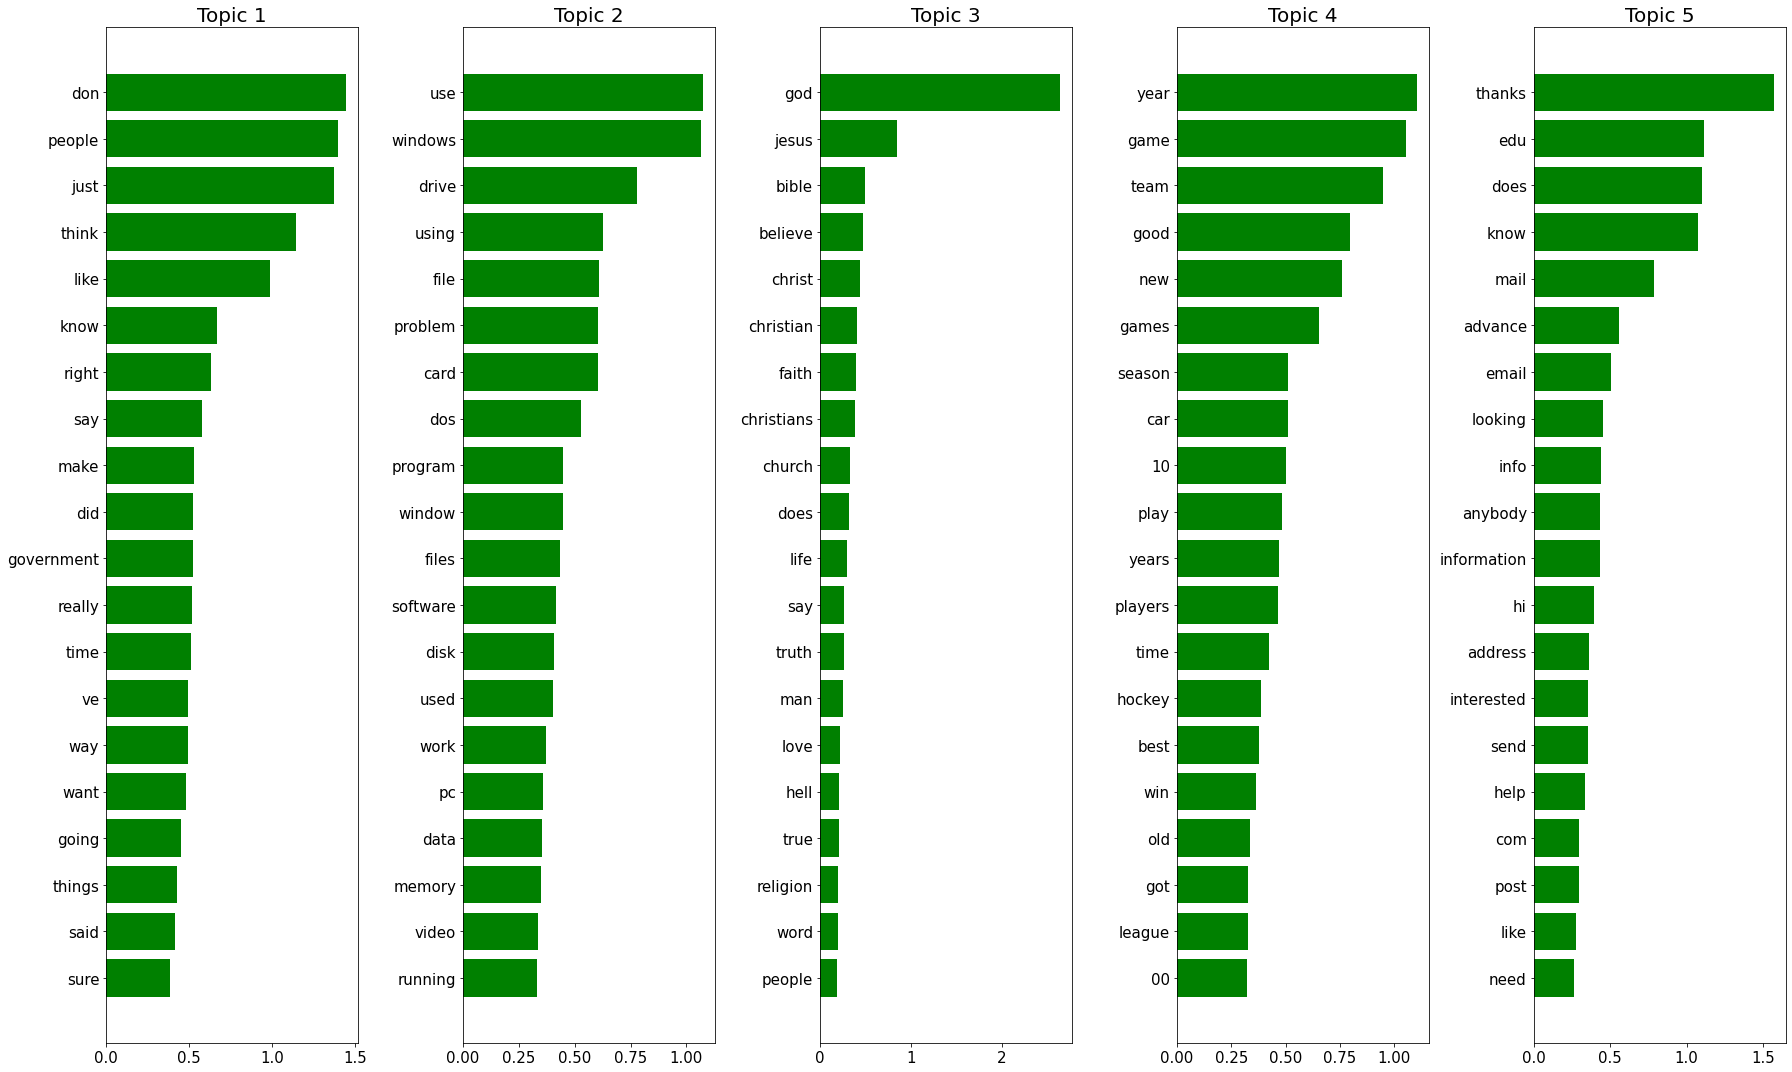

In [15]:
# Try NMF for 5 topics
try_NMF(5, data)

## Non-conformance dataset (internal dataset)

In [9]:
# Get from csv to dictionary
dict_csv = pd.read_csv('/Users/castrma/Projects/DT/svt-data-processing/others/csv/notification_long_text.csv', 
header=None, index_col=0, squeeze=True).to_dict()
#print(dict_csv)

In [10]:
#create a list of non-conformance
internal_data = dict_csv.values()

#Remove NaN from list
internal_data = [x for x in internal_data if pd.isnull(x) == False]

In [20]:
print(f"Data has {len(internal_data)} elements.\n")
print(f"First element: \n")
#for n, d in enumerate(internal_data[:1], start=1):
#  print("======"*10)
#  print(f"Element number {n}:\n\n{d}\n")

Data has 386102 elements.

First element: 



Data has shape (386102, 500) after vectorization.
Each data point has shape (1, 500) after vectorization.


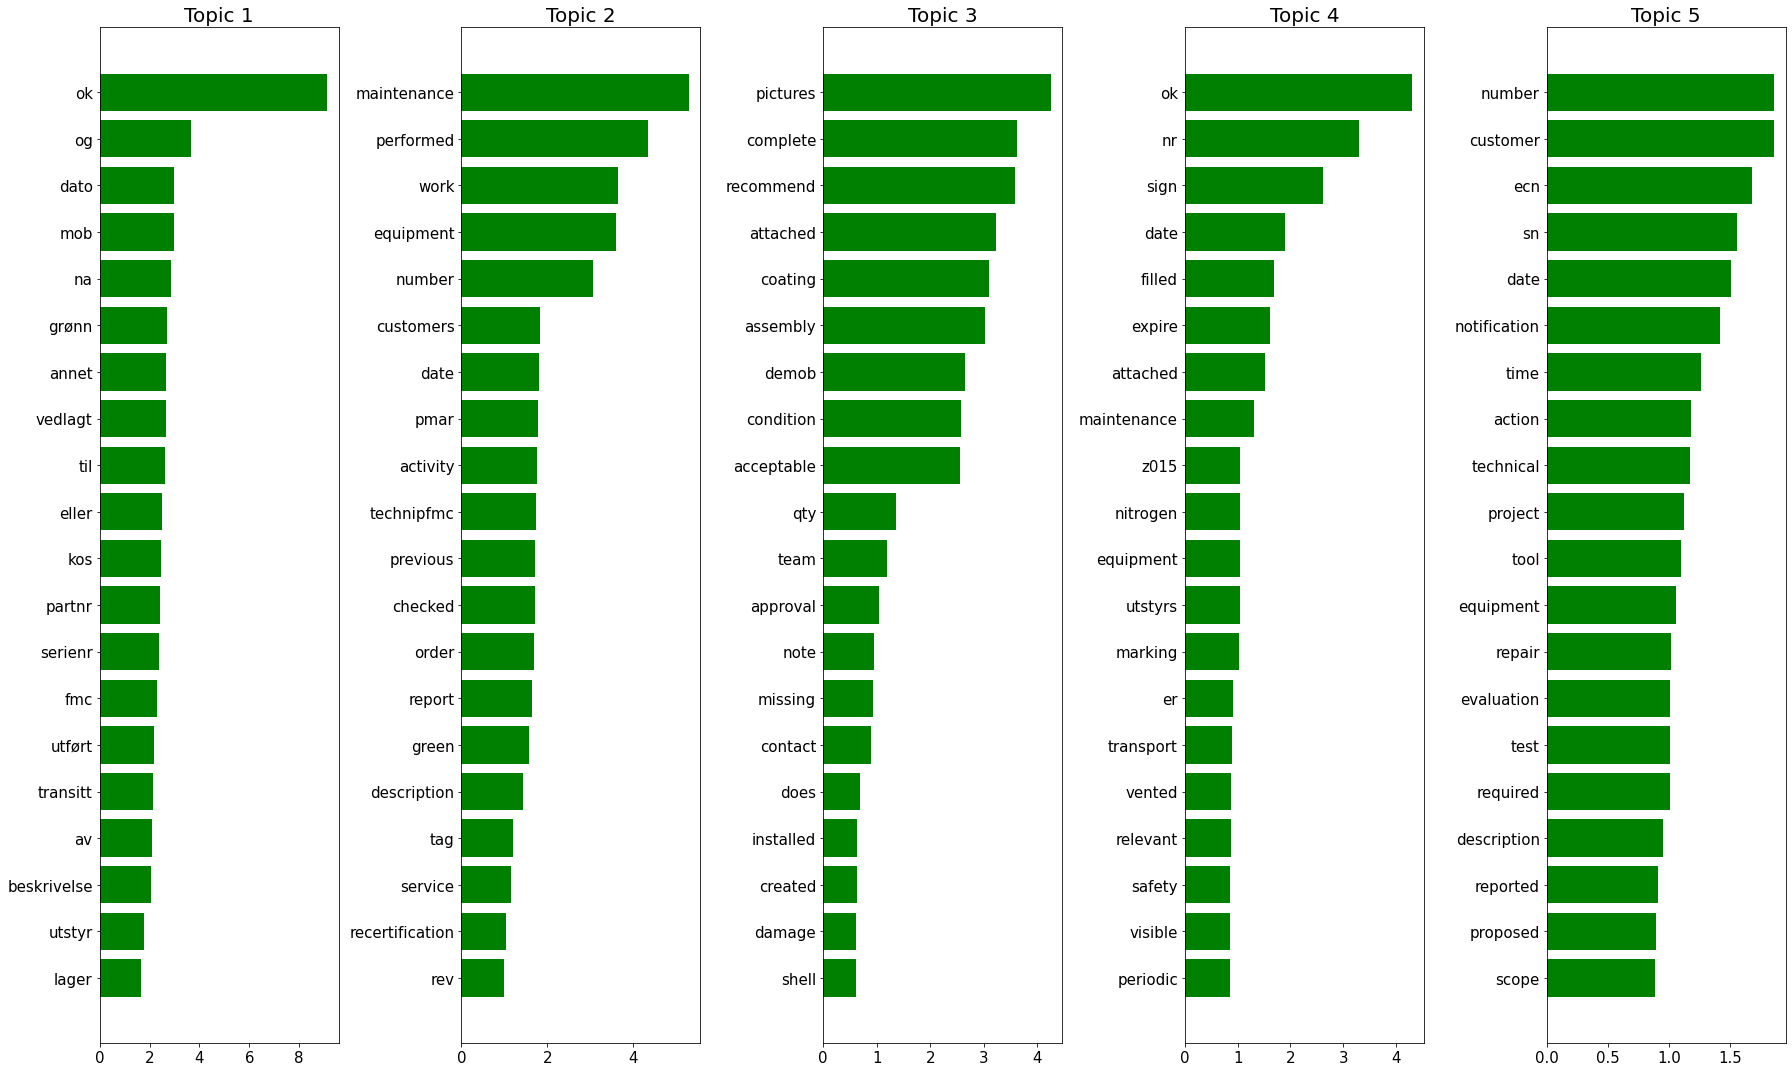

In [21]:
try_NMF(5, internal_data)

In [13]:
#print(f"Original text:\n{data[0]}\n")
#print(next(iter(data)))

#print(f"Representation based on topics:\n{vect_data_internal[0]}")

In [18]:
#Function that  
def NMFv2(n_comp, data):
  '''
  input: 
  n_comp = number of components
  vect_data = data matrix to be decomposed
  
  output:
  plot words for topics
  '''
  vectorizer, vect_data = get_vector(data)
  #beta_loss: beta divergence to be minimized
  #solver: numerical solver to use. mu = Multiplicative Update solver
  #max_iter: maximum number of iterations before timing out.
  #alpha: constant that multiplies the regularization terms
  #l1_ratio: the regularization mixing parameter
  nmf = NMF(n_components=n_comp, random_state=42,
        beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1,
      l1_ratio=.5)
  # Lets learn a NMF model for the vect_data
  nmf.fit(vect_data)
  feature_names = vectorizer.get_feature_names()
  plot_words_for_topics(n_comp, nmf, feature_names)

Data has shape (386102, 500) after vectorization.
Each data point has shape (1, 500) after vectorization.


/Users/castrma/miniconda3/envs/tensorflow_py37/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:315: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  "'nndsvda' in 1.1 (renaming of 0.26)."), FutureWarning)


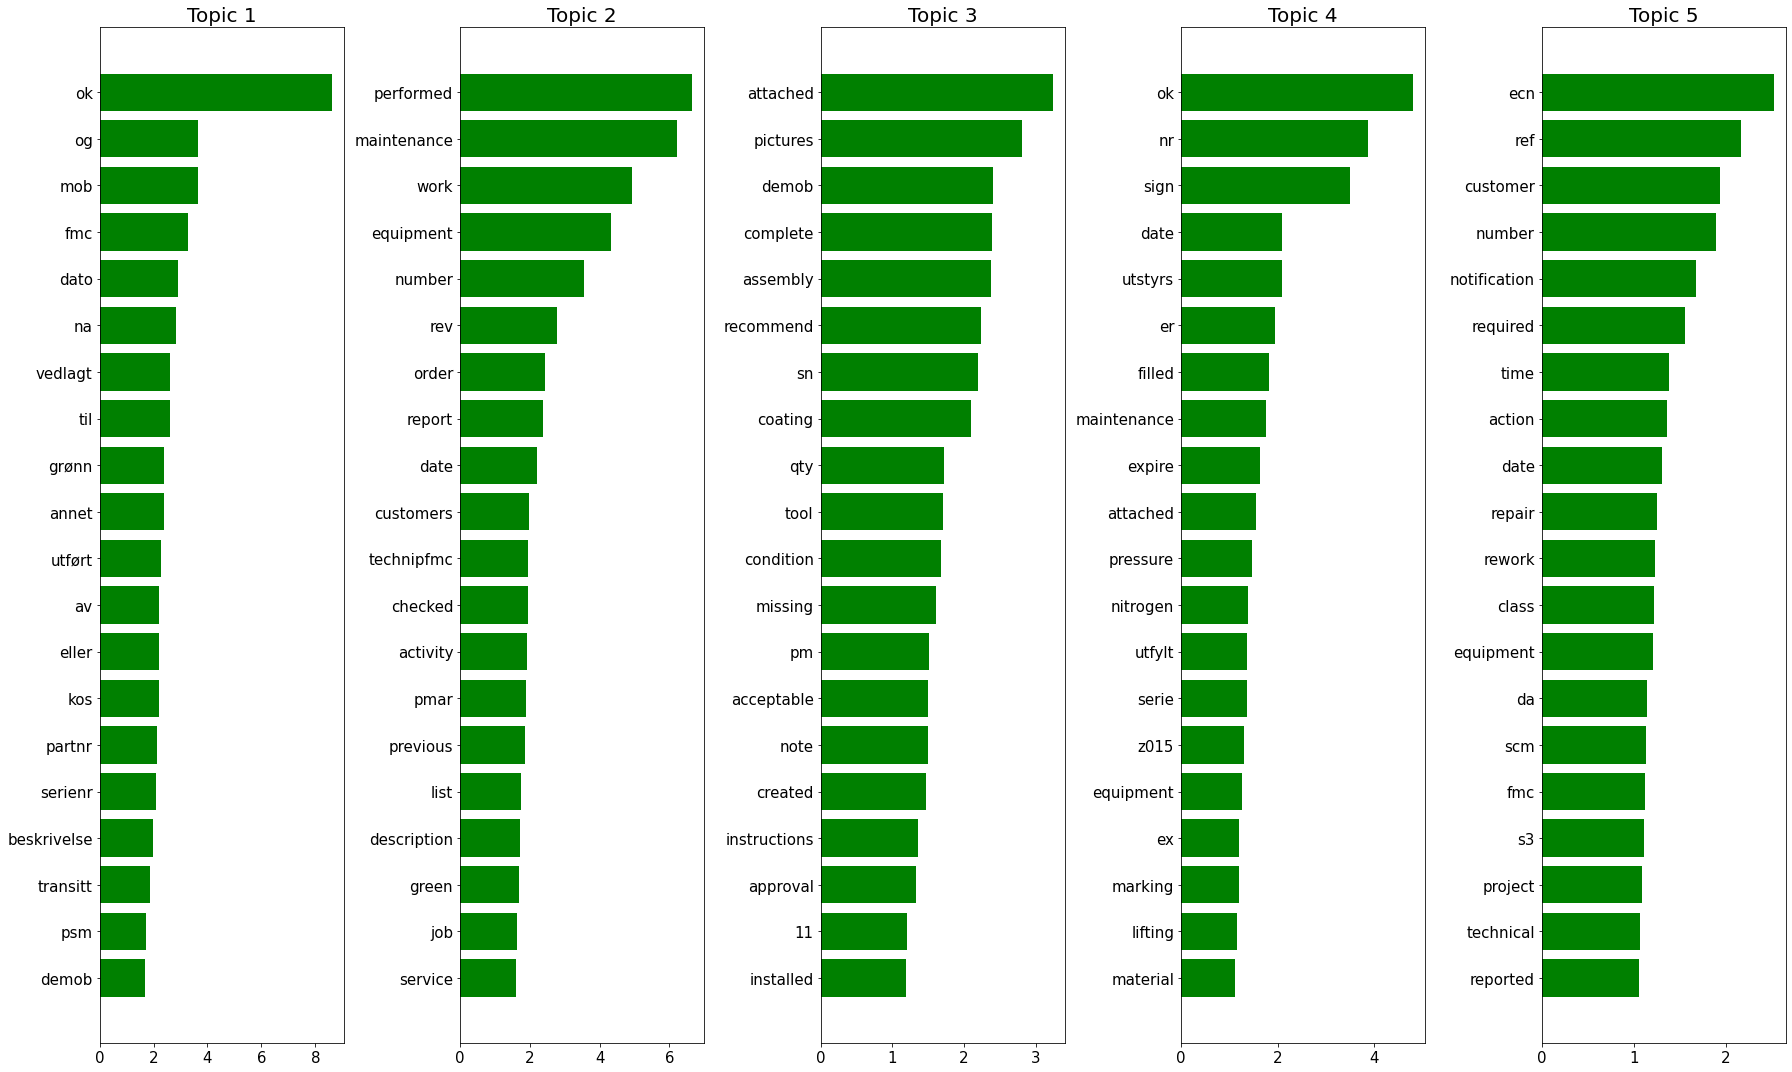

In [19]:
NMFv2(5, internal_data)